# Initialisation

In [31]:
# Install and load the latex2exp package, for printing mathematical symbols in R
packageName<-"latex2exp" #install the arules library that provides the discretization function
if (!require(packageName, character.only = TRUE)) {
  install.packages(packageName)
  library(packageName, character.only = TRUE)
}

Loading required package: latex2exp



In [11]:
setwd("../datasets/")
data <- read.table (file="HR_prediction-all.csv",sep=",", header=T)

In [12]:
nb_instances <- nrow(data)
nb_attributes <- ncol(data)

qualitatives_attributes_col_idx <- c(7,9,10,11)
quantitatives_attributes_col_idx <- c(2,3,4,5,6)
target_variables_idx <- 8

# Descriptive Analysis

In [13]:
print(paste("Number of instances : ", nb_instances))
print(paste("Number of attributes : ", nb_attributes))

[1] "Number of instances :  10000"
[1] "Number of attributes :  11"


In [14]:
summary(data)

       Id        satisfaction_level last_evaluation  number_project 
 Min.   :    3   Min.   :0.090      Min.   :0.3600   Min.   :2.000  
 1st Qu.: 3728   1st Qu.:0.440      1st Qu.:0.5600   1st Qu.:3.000  
 Median : 7434   Median :0.640      Median :0.7200   Median :4.000  
 Mean   : 7471   Mean   :0.614      Mean   :0.7176   Mean   :3.799  
 3rd Qu.:11243   3rd Qu.:0.820      3rd Qu.:0.8700   3rd Qu.:5.000  
 Max.   :14999   Max.   :1.000      Max.   :1.0000   Max.   :7.000  
 average_montly_hours time_spend_company Work_accident         left       
 Min.   : 96.0        Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0        1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :199.0        Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :200.7        Mean   : 3.494     Mean   :0.1459   Mean   :0.2381  
 3rd Qu.:245.0        3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :310.0        Max.   :10.000     Max.   :1.0000   Max.   :1

In [15]:
# SRC :https://www.geeksforgeeks.org/how-to-find-and-count-missing-values-in-r-dataframe/
# find location of missing values
print("Position of missing values ")
which(is.na(data))
 
# count total missing values 
print("Count of total missing values  ")
sum(is.na(data))

#SRC : https://www.datacamp.com/doc/r/missingdata
# list rows of data that have missing values
data[!complete.cases(data),]

[1] "Position of missing values "


integer(0)

[1] "Count of total missing values  "


[1] 0

Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>


# Qualitatives Attributes

In [17]:
# SRC :https://stat.ethz.ch/R-manual/R-devel/library/base/html/unique.html
#SRC https://www.statology.org/r-loop-through-data-frame-columns/
# Methods 1
sapply(data[, qualitatives_attributes_col_idx], unique)

$Work_accident
[1] 0 1

$promotion_last_5years
[1] 0 1

$department
 [1] "marketing"   "sales"       "accounting"  "product_mng" "support"    
 [6] "technical"   "IT"          "management"  "hr"          "RandD"      

$salary
[1] "medium" "low"    "high"

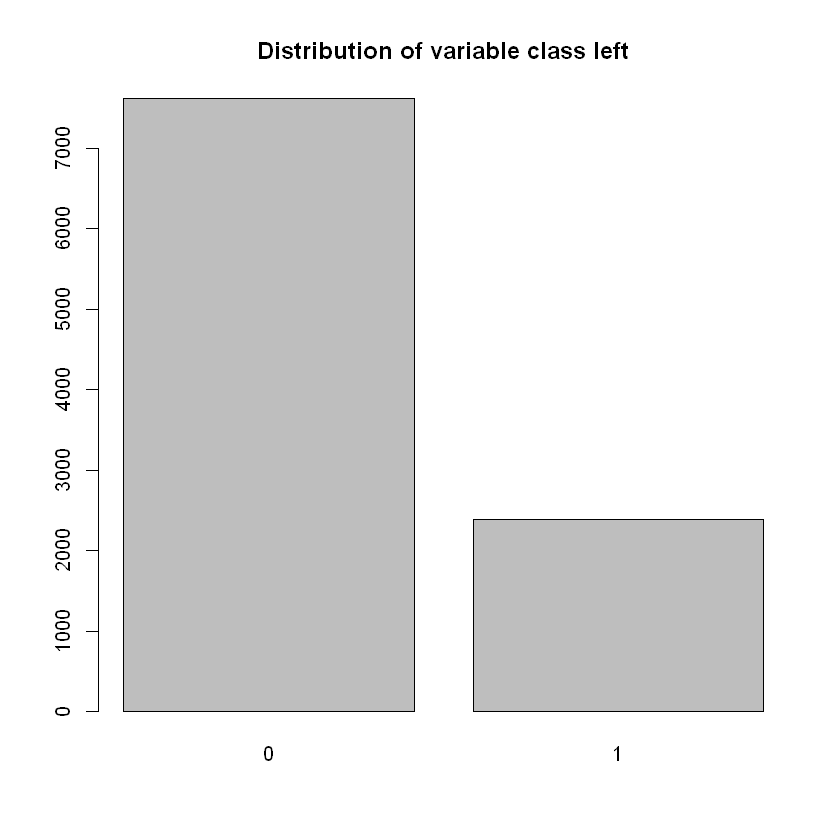

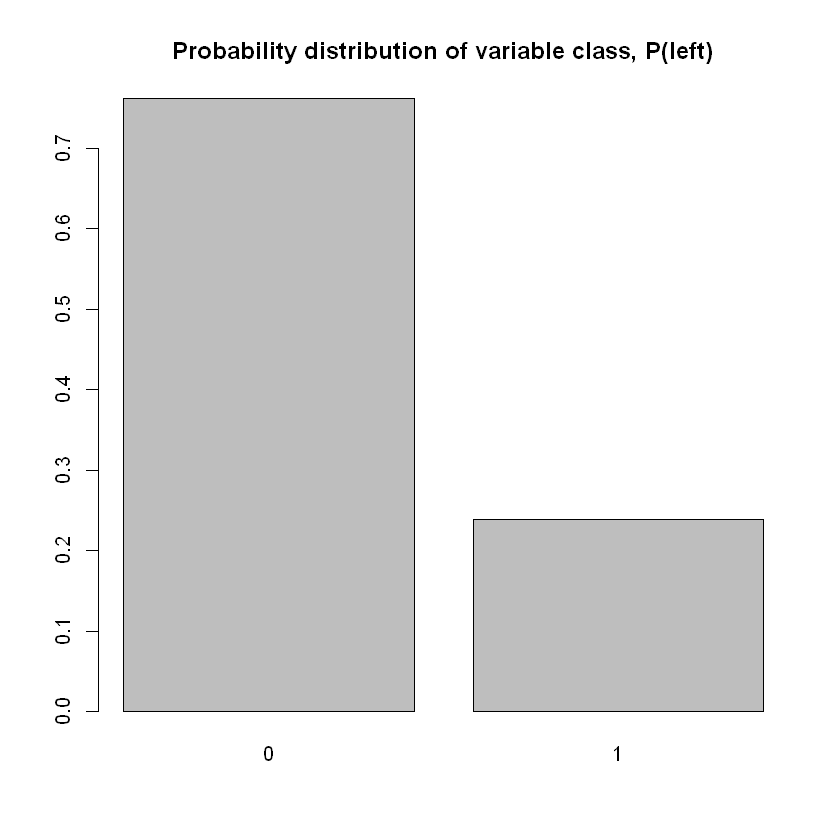

In [18]:
#Distribution and probability of P(target)
target.counts <- table(data[, target_variables_idx])
P.target <- prop.table(target.counts)
barplot(target.counts, main=paste0("Distribution of variable class ", colnames(data)[target_variables_idx]))
barplot(P.target, main=paste0("Probability distribution of variable class, P(", colnames(data)[target_variables_idx], ")"))


In [19]:
plot_probabilities <- function(data, variable_idx, target_idx) {


    # Get the names of the variable and target variable
    var_name <- trimws(colnames(data)[variable_idx])
    target_name <- trimws(colnames(data)[target_idx])
    
    # Calculate the probability distribution P(variable)
    P_var <- prop.table(table(data[, variable_idx]))
    print(P_var)  # Display the probability distribution
        
    # Calculate the conditional probability P(target|variable)
    # Example : Observing employe who left the company among the employe who had a work accident instance
    # P(left=1 | work_accident = 1)
    P_target_given_var <- prop.table(table(data[, c(target_idx, variable_idx)]), margin = 2)
    print(P_target_given_var)  # Display the conditional probability

    # Set working directory to the folder of the script
    #setwd(normalizePath(dirname(sys.frame(1)$ofile)))
    setwd("C:/Users/huniv/jnotebook/data-mining/62-62_Data_Mining/tp01/")
  
    # Ensure output directory exists
    if (!dir.exists("./output")) {
        dir.create("./output")
    }
  
    # Create the full path for the PDF file
    full_pdf_path <- file.path("./output", paste0(var_name, ".pdf"))
  
    # Open a PDF to save the plots
    pdf(file = paste(full_pdf_path), width = 12, height = 6)

    # Set up a 1-row, 2-column layout for the plots
    par(mfrow = c(1, 2), mar = c(5, 4, 4, 6) + 0.1)  # Adjust margins for better space for the legend
  
    # Visualize the probability distribution P(variable)
    barplot(P_var, 
            main = paste0("Probability Distribution P(", var_name, ")"), 
            xlab = paste0("Category of ", var_name), 
            ylab = "Probability"
    ) 
    #legend = TRUE,
    #args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n")
    
    # Visualize the conditional probability P(target|variable)
    barplot(P_target_given_var, 
            beside = FALSE,  # Separate bars for each target category
            main = paste0("Conditional Probability P(", target_name, "|", var_name, ")"), 
            xlab = paste0("Category of ", var_name), 
            ylab = "Conditional Probability", 
            legend.text = rownames(P_target_given_var),
            args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n")
    )
    
    # Close the PDF device
    dev.off()
    
}

In [25]:
# Define the index of the variable and target variable
for (i in qualitatives_attributes_col_idx) {
    plot_probabilities(data, i, target_variables_idx)
}


     0      1 
0.8541 0.1459 
    Work_accident
left          0          1
   0 0.73492565 0.91980809
   1 0.26507435 0.08019191

     0      1 
0.9789 0.0211 
    promotion_last_5years
left          0          1
   0 0.75799367 0.94312796
   1 0.24200633 0.05687204

         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1481      0.1781 
    department
left        IT     RandD accounting        hr management marketing product_mng
   0 0.7793939 0.8587786  0.7272727 0.7335984  0.8452381 0.7676951   0.7976974
   1 0.2206061 0.1412214  0.2727273 0.2664016  0.1547619 0.2323049   0.2023026
    department
left     sales   support technical
   0 0.7494624 0.7461175 0.7422796
   1 0.2505376 0.2538825 0.2577204

  high    low medium 
0.0790 0.4885 0.4325 
    salary
left       high        low     medium
   0 0.93924051 0.700

In [23]:
QualitativeAttrsTheory <- function(data, variable_idx, target_idx) {
        
    var_name <- trimws(colnames(data)[variable_idx])
    target_name <- trimws(colnames(data)[target_idx])
    
    # Calculate the joint probability distribution
    title <- paste("P(",var_name,",",target_name,")")
    P.var.target <- prop.table(table(data[,c(variable_idx,target_idx)]))
    barplot(P.var.target, main=title, legend=T)
  
    print("P(target, var):")
    print(P.var.target)
    print("########################")
    
    # Caculate marginale distribution P(Target)
    print("P(target):")
    P.target <- colSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,target_idx])))
    print(P.target)
    print("########################")

    # Caculate marginale distribution P(Variable)
    print("P(var):")
    P.var <- rowSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,variable_idx])))
    print(P.var)
    print("########################")
    
    P.target.given.var <- sweep(P.var.target,1,P.var, FUN="/")
    print("P(target|var):")
    print(P.target.given.var)
    print("Check:")
    print(rowSums(P.target.given.var))
    print("########################")

    P.var.given.target <- sweep(P.var.target,2,P.target, FUN="/")
    print("P(var|target):")
    print(P.var.given.target)
    print("Check:")
    print(colSums(P.var.given.target))
    print("########################")
}

[1] "P(target, var):"
        left
salary        0      1
  high   0.0742 0.0048
  low    0.3421 0.1464
  medium 0.3456 0.0869
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

  high    low medium 
0.0790 0.4885 0.4325 
  high    low medium 
0.0790 0.4885 0.4325 
[1] "########################"
[1] "P(target|var):"
        left
salary            0          1
  high   0.93924051 0.06075949
  low    0.70030706 0.29969294
  medium 0.79907514 0.20092486
[1] "Check:"
  high    low medium 
     1      1      1 
[1] "########################"
[1] "P(var|target):"
        left
salary            0          1
  high   0.09738811 0.02015960
  low    0.44900906 0.61486770
  medium 0.45360284 0.36497270
[1] "Check:"
0 1 
1 1 
[1] "########################"


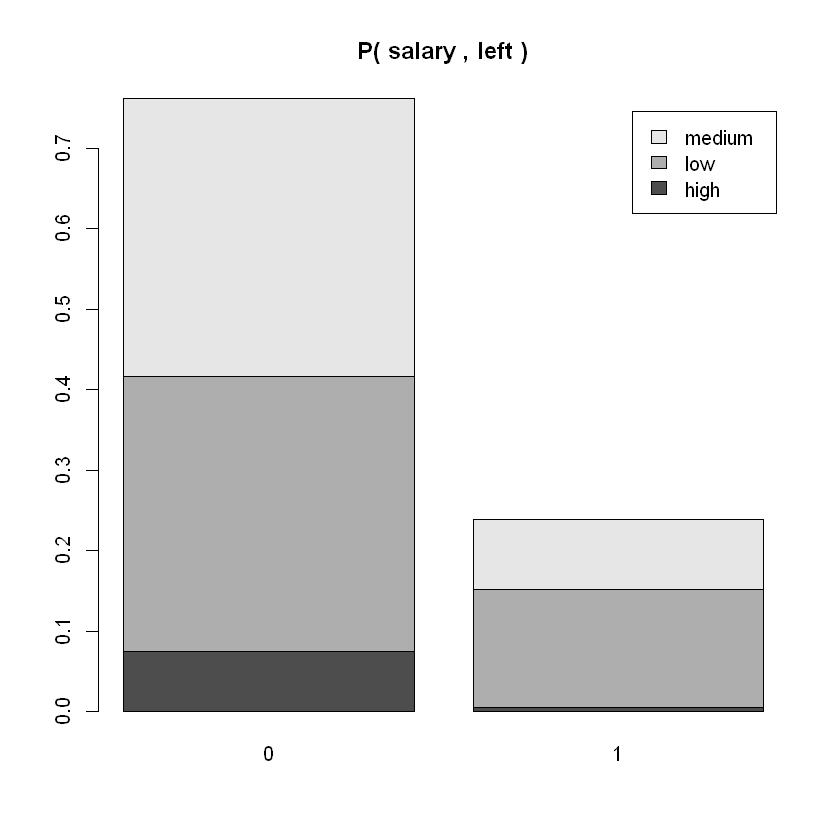

In [24]:
    QualitativeAttrsTheory(data, 11,target_variables_idx)

# Quantitatives Attributes

In [91]:
generateQuantitativeAttributesAnalysisSummary <- function(data, target_variables_idx, quantitatives_attributes_col_idx){
  #Calculate means
  overallMeans <- colMeans(data[,quantitatives_attributes_col_idx])

  #Calculate variances 
  overallVar <- apply(data[, quantitatives_attributes_col_idx], 2, var)
  
  # TODO : Generalize this part to loop on the Target Value and generate each conditional means
  #Calculate conditional means P(f|left=0)
  condMeansStay <- colMeans(data[data[,target_variables_idx]==0,quantitatives_attributes_col_idx])

  #Calculate conditional Means P(f|left=1)
  condMeansLeft <- colMeans(data[data[,target_variables_idx]==1,quantitatives_attributes_col_idx])

  #Calculate Standard deviations
  stdDevs <- sqrt(diag(var(data[,quantitatives_attributes_col_idx])))

  attributesScore<-abs(condMeansLeft-condMeansStay)/stdDevs

  summary <- data.frame(
    Mean = overallMeans,
    Variance = overallVar,
    Mean_Stay = condMeansStay,
    Mean_Left = condMeansLeft,
    Std_Dev = stdDevs,
    Importance_Score = attributesScore
  )
  
  sorted_summary <- summary[order(-summary$Importance_Score), ]  # Sort by Importance Score descending

  return(sorted_summary)
}

saveQuantitativeAttributesAnalysisSummary <- function(wd, folderName, fileName, summary){
  # Install packages if not already installed
  if (!requireNamespace("gridExtra", quietly = TRUE)) {
    install.packages("gridExtra")
  }
  if (!requireNamespace("png", quietly = TRUE)) {
    install.packages("png")
  }

  # Load required libraries
  library(gridExtra)
  library(grid)
  # Set working directory to the folder of the script
  #setwd(normalizePath(dirname(sys.frame(1)$ofile)))
  setwd(wd)

  # Ensure output directory exists
  output_dir <- file.path(wd, folderName)
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }

  # Construct full file path for saving the PNG
  full_file_path <- file.path(output_dir, paste0(fileName, ".png"))

  # Save the table as a PNG
  png(full_file_path, width = 1000, height = 600)
  grid.table(summary)
  dev.off()
}


In [92]:
summary <- generateQuantitativeAttributesAnalysisSummary(data, target_variables_idx, quantitatives_attributes_col_idx)
saveQuantitativeAttributesAnalysisSummary(
  "C:/Users/huniv/jnotebook/data-mining/62-62_Data_Mining/tp01/", 
  "output", 
  "quantitative_attributes_summary_table",
  summary
)


png 
  2

In [73]:
# Function to visualize the empirical distribution of a quantitative attribute
visualizeEmpiricalDistributionOfQuantitativeAttribute <- function(data, idx) {

  # Calculate summary statistics for the attribute
  avg <- mean(data[, idx])
  var <- var(data[, idx])
  stdDev <- sqrt(var)

  # Create the histogram and save its output
  hist_output <- hist(data[, idx],
                      main = paste("Empirical distribution of ", names(data)[idx]),
                      xlab = names(data)[idx],
                      breaks = 20)

  # Draw a vertical line for the mean
  abline(v = avg, col = "red")

  # Extract the maximum frequency from the histogram output
  max_frequency <- max(hist_output$counts)

  # Set the y value for text labels and lines relative to the histogram height
  y_line <- max_frequency * 0.1       # Set line height at 10% of the max frequency for visibility
  y_text_sd <- max_frequency * 0.15   # Set text height slightly above the line
  y_text_34 <- max_frequency * 0.5    # Set "34% of data" labels around 50% of the max frequency for better visibility

  #######################################################
  # Draw a line representing the standard deviation range
  # This region theoretically contains 68% of the data on each side around the mean if the attribute is normally distributed
  points(x = c(avg - stdDev, avg + stdDev), y = c(y_line, y_line), type = "l", col = "darkgreen")

  # Add labels for μ - σ and μ + σ
  text(x = avg - stdDev, y = y_text_sd, labels = TeX("$\\mu_X-\\sigma_X$"), col = "blue", cex = 1)
  text(x = avg + stdDev, y = y_text_sd, labels = TeX("$\\mu_X+\\sigma_X$"), col = "blue", cex = 1)

  # Draw vertical lines at μ - σ and μ + σ
  abline(v = avg - stdDev, col = "darkgreen")
  abline(v = avg + stdDev, col = "darkgreen")

  # Add labels indicating "34% of data" on either side of the mean
  text(x = avg - 0.5 * stdDev, y = y_text_34, labels = "34% of data", col = "blue", cex = 1)
  text(x = avg + 0.5 * stdDev, y = y_text_34, labels = "34% of data", col = "blue", cex = 1)
  #######################################################
}

In [74]:
# Function to visualize conditional distributions of an attribute for two groups
visualizeConditionalDistribution <- function(data, idx, target_idx) {

  # Calculate the range for the bins
  minX <- min(data[, idx])
  maxX <- max(data[, idx])
  breaks <- seq(from = minX, to = maxX, length.out = 20)

  # Print the breaks for debugging purposes
  print(breaks)

  # Create the histogram for people who left (target variable = 1)
  hist(
    data[data[, target_idx] == 1, idx],
    col = rgb(red = 1, green = 0, blue = 0, alpha = 0.5),
    xlab = names(data)[idx],
    main = paste("Density of", names(data)[idx], "for P(", names(data)[idx], "| left=1), P(", names(data)[idx], "| left=0)"),
    breaks = breaks,
    freq = FALSE
  )

  # Add the histogram for people who stayed (target variable = 0)
  hist(
    data[data[, target_idx] == 0, idx],
    col = rgb(red = 0, green = 1, blue = 0, alpha = 0.5),
    breaks = breaks,
    freq = FALSE,
    add = TRUE
  )

  # Add a legend to the plot
  legend("topright",
         legend = c("left=0", "left=1"),
         fill = c(rgb(red = 0, green = 1, blue = 0, alpha = 0.5),
                  rgb(red = 1, green = 0, blue = 0, alpha = 0.5)))
}


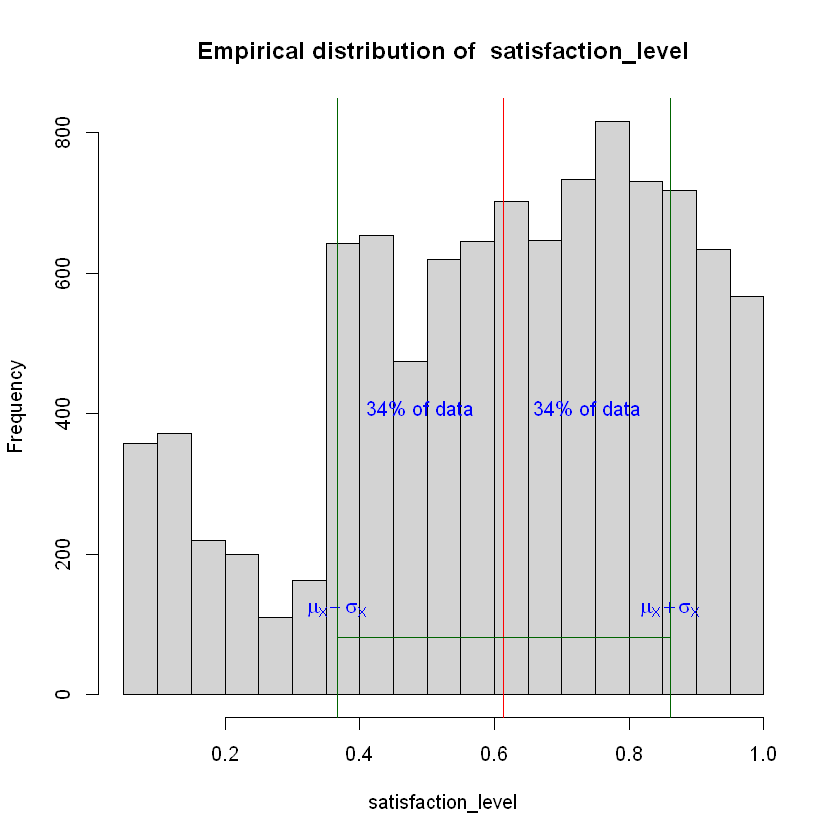

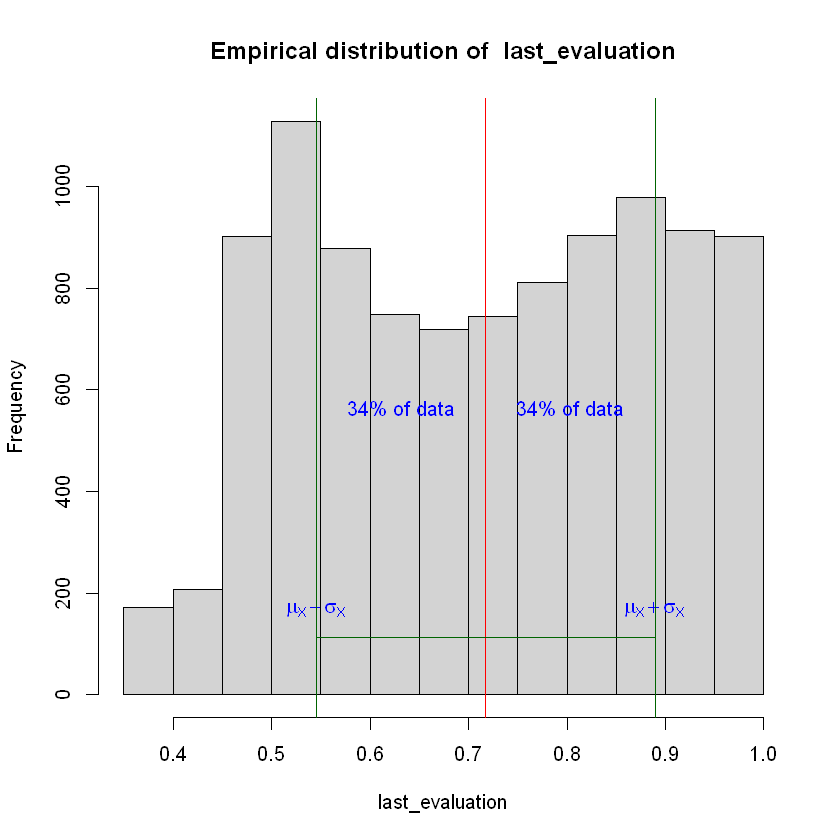

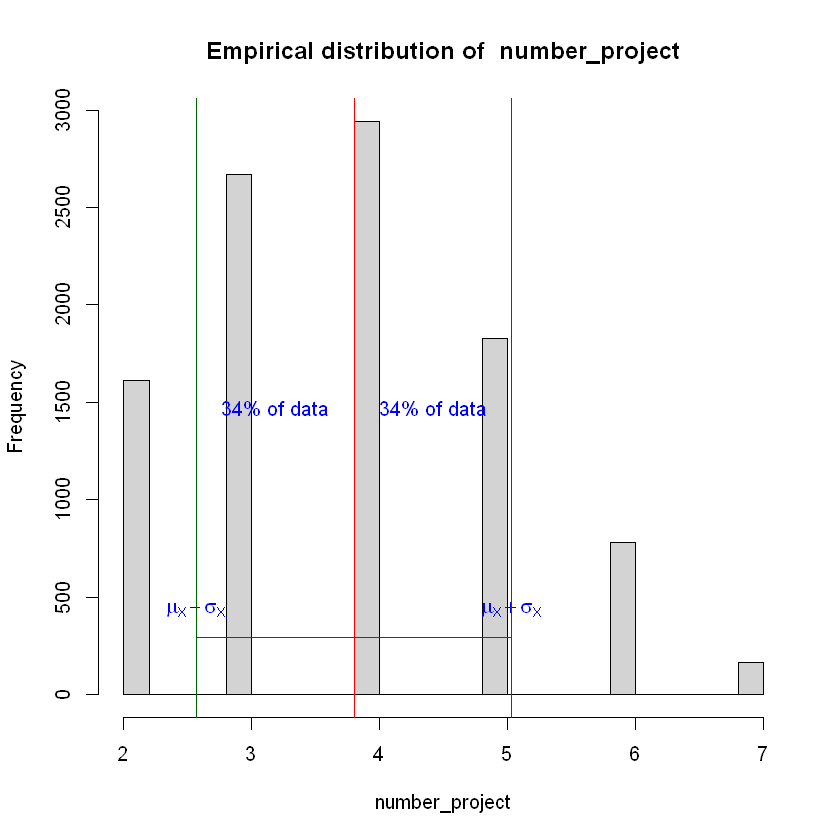

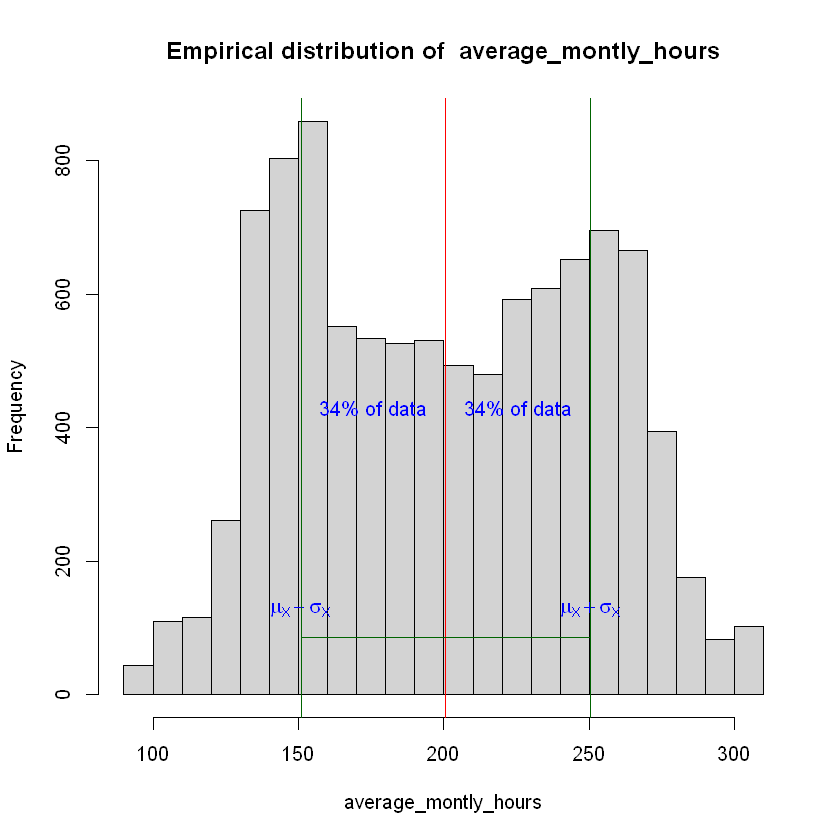

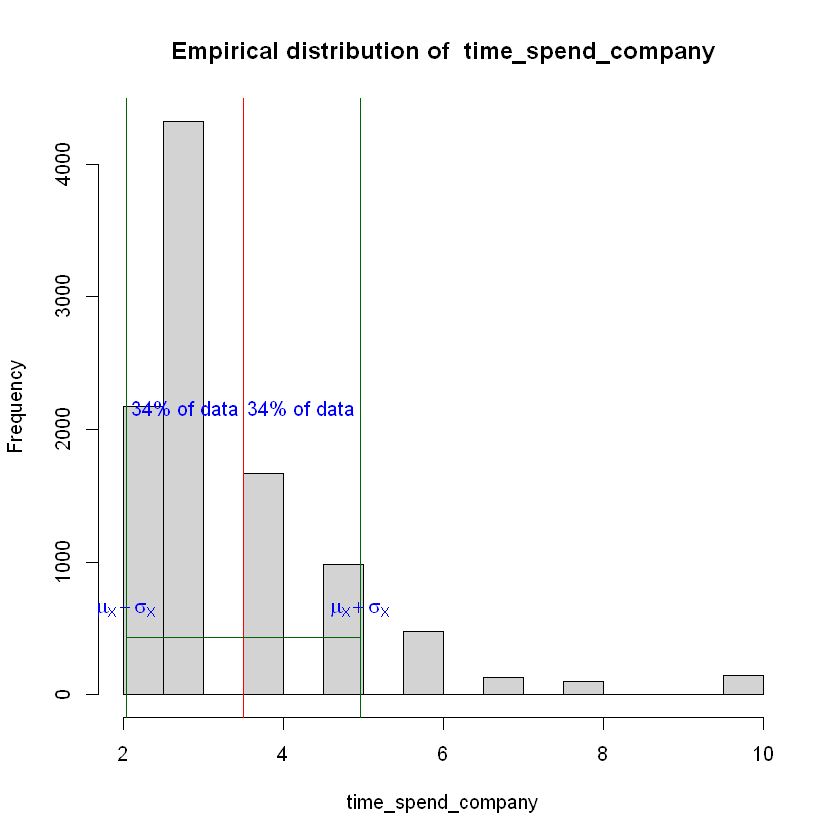

In [75]:
# Define the index of the variable and target variable
for (i in quantitatives_attributes_col_idx) {
  visualizeEmpiricalDistributionOfQuantitativeAttribute(data, i)
}

 [1] 0.0900000 0.1378947 0.1857895 0.2336842 0.2815789 0.3294737 0.3773684
 [8] 0.4252632 0.4731579 0.5210526 0.5689474 0.6168421 0.6647368 0.7126316
[15] 0.7605263 0.8084211 0.8563158 0.9042105 0.9521053 1.0000000
 [1] 0.3600000 0.3936842 0.4273684 0.4610526 0.4947368 0.5284211 0.5621053
 [8] 0.5957895 0.6294737 0.6631579 0.6968421 0.7305263 0.7642105 0.7978947
[15] 0.8315789 0.8652632 0.8989474 0.9326316 0.9663158 1.0000000


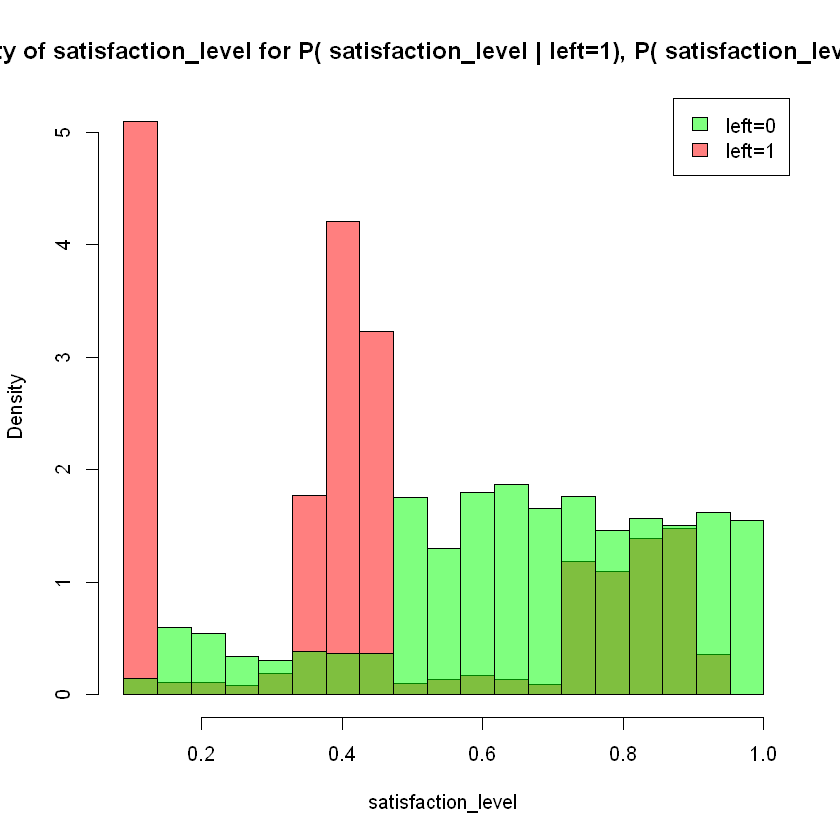

 [1] 2.000000 2.263158 2.526316 2.789474 3.052632 3.315789 3.578947 3.842105
 [9] 4.105263 4.368421 4.631579 4.894737 5.157895 5.421053 5.684211 5.947368
[17] 6.210526 6.473684 6.736842 7.000000


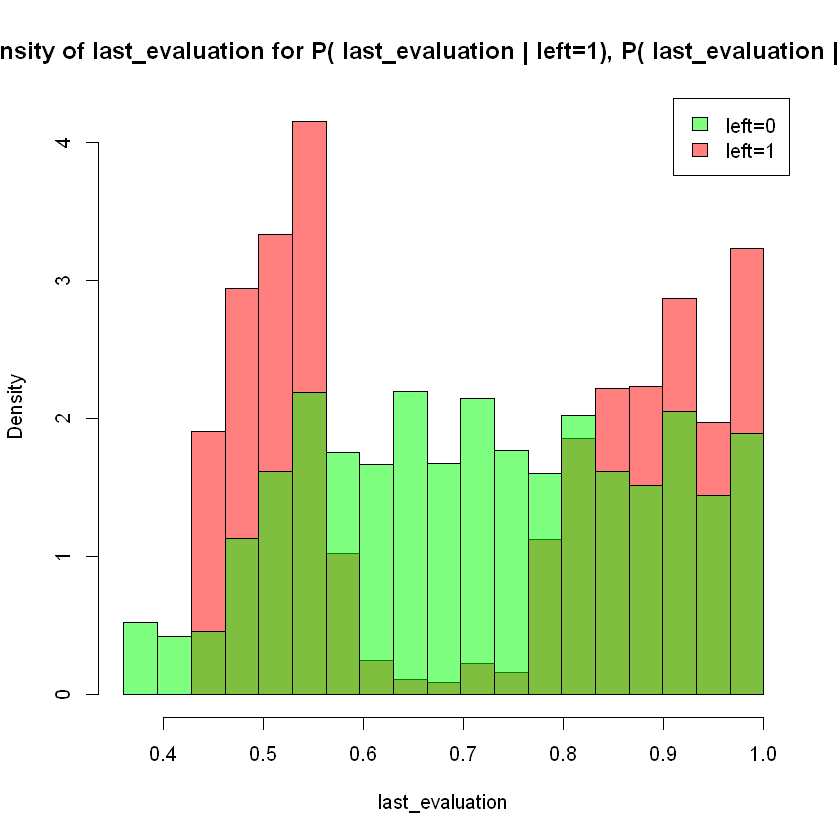

 [1]  96.0000 107.2632 118.5263 129.7895 141.0526 152.3158 163.5789 174.8421
 [9] 186.1053 197.3684 208.6316 219.8947 231.1579 242.4211 253.6842 264.9474
[17] 276.2105 287.4737 298.7368 310.0000


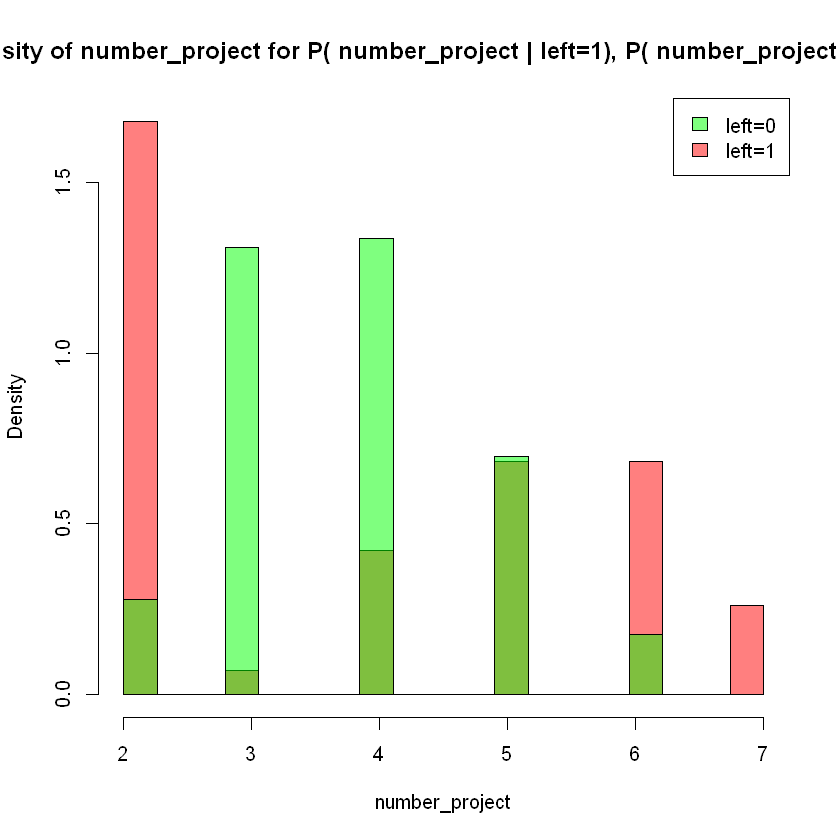

 [1]  2.000000  2.421053  2.842105  3.263158  3.684211  4.105263  4.526316
 [8]  4.947368  5.368421  5.789474  6.210526  6.631579  7.052632  7.473684
[15]  7.894737  8.315789  8.736842  9.157895  9.578947 10.000000


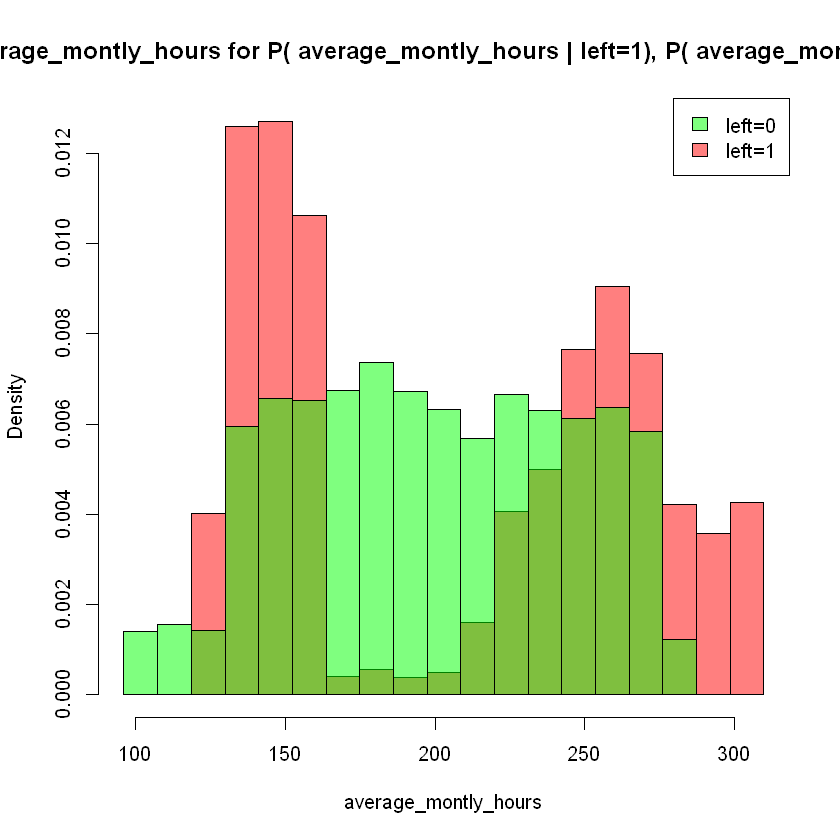

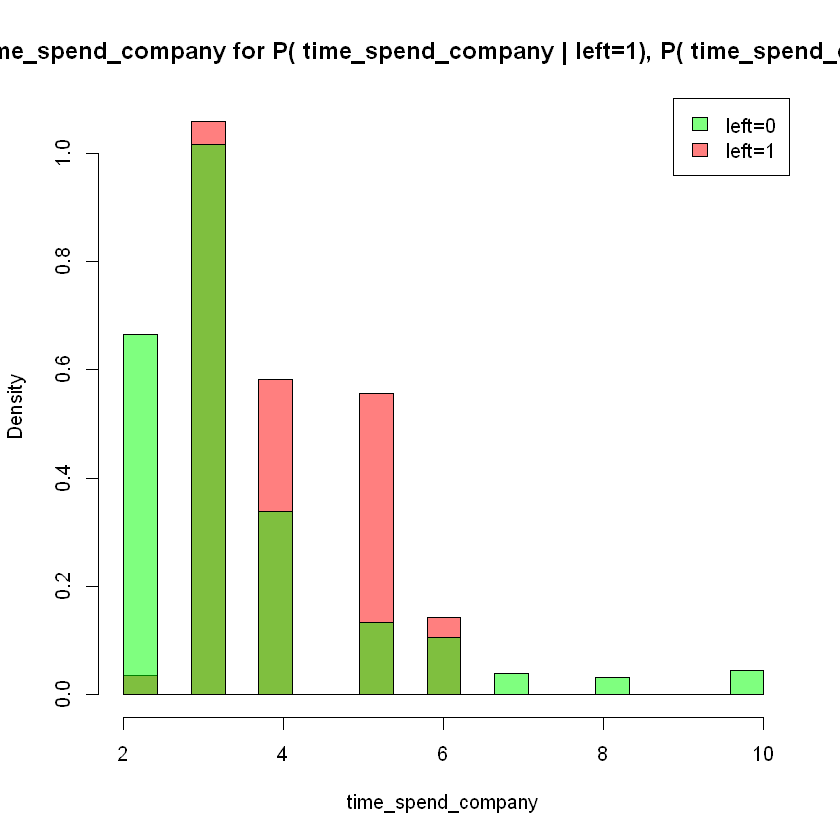

In [76]:
# Define the index of the variable and target variable
for (i in quantitatives_attributes_col_idx) {
  visualizeConditionalDistribution(
    data, 
    i, 
    target_variables_idx)
}

[1] "Top two most important attributes: satisfaction_level"
[2] "Top two most important attributes: last_evaluation"   
[1] 1


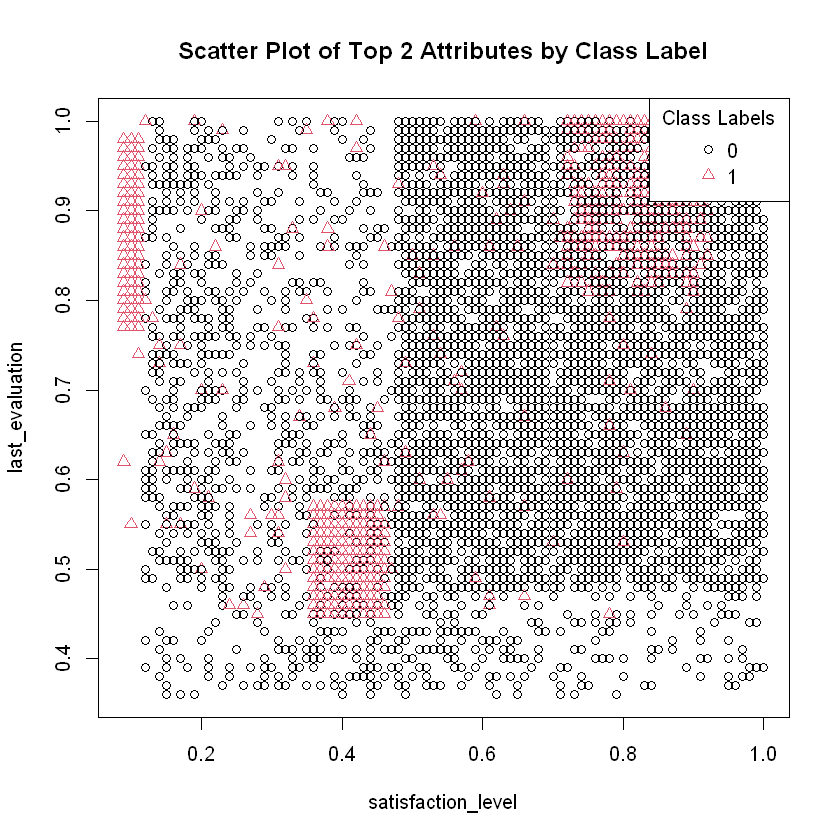

In [107]:
# Function to create a scatter plot for the top two most important quantitative attributes
scatterPlotTopTwoAttributes <- function(data, quantitatives_attributes_col_idx, target_variables_idx) {

  # Generate summary of quantitative attributes
  summary <- generateQuantitativeAttributesAnalysisSummary(data, target_variables_idx, quantitatives_attributes_col_idx)

  # Extract the two most important attributes based on Importance Score
  top_attributes_idx <- order(-summary$Importance_Score)[1:2]

  # Print the names of the two most important attributes
  print(paste("Top two most important attributes:", colnames(data)[quantitatives_attributes_col_idx[top_attributes_idx]]))

  # Extract the columns for the top two attributes
  x <- data[, quantitatives_attributes_col_idx[top_attributes_idx[1]]]
  y <- data[, quantitatives_attributes_col_idx[top_attributes_idx[2]]]
  target <- factor(data[, target_variables_idx])
  
  print(top_attributes_idx[1])

  # Create the scatter plot
  plot(
    x, y,
    col = target,
    pch = as.numeric(target),
    xlab = colnames(data)[quantitatives_attributes_col_idx[top_attributes_idx[1]]],
    ylab = colnames(data)[quantitatives_attributes_col_idx[top_attributes_idx[2]]],
    main = "Scatter Plot of Top 2 Attributes by Class Label"
  )

  # Add a legend to the plot
  legend("topright",
         legend = levels(target),
         col = 1:length(levels(target)),
         pch = 1:length(levels(target)),
         title = "Class Labels")
}

# Example usage
scatterPlotTopTwoAttributes(data, quantitatives_attributes_col_idx, target_variables_idx)
